In [1]:
# Connecting the notebook to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [3]:
# Data augmentation/pre-processing and normalization for training
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
#Data path
data_dir = "/content/drive/MyDrive/image_Classification_Pytorch/Classification Dataset"
#Load data
Datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
              for x in ['Train', 'Val']}

#Define Train and Validation Dataloaders
dataloaders = {x: torch.utils.data.DataLoader(Datasets[x], batch_size=5,
                                             shuffle=True, num_workers=0)
              for x in ['Train', 'Val']}

dataset_sizes = {x: len(Datasets[x]) for x in ['Train', 'Val']}
print(dataset_sizes)

class_names = Datasets['Val'].classes
print(class_names)

{'Train': 303, 'Val': 49}
['Bread', 'Coffee', 'Pasta']


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train_model(model, lossFunction, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Val']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunction(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

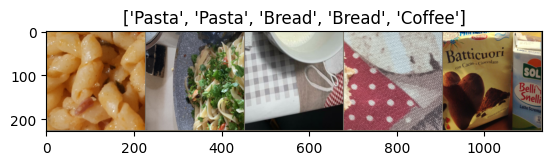

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            percentage = torch.sigmoid(outputs)[0] * 100
            _, indices = torch.sort(outputs, descending=True)
            probs=[percentage[idx].item() for idx in indices[0][:4]]

            classes=[class_names[idx] for idx in indices[0][:4]]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 5, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
import torchvision
from torchvision import models
import torch.nn as nn

In [10]:
#Transfer Learning by fineTuning the pretrained Resnet101 Model
#Load Resnet101 pretained Model
#Resnet101 = models.resnet101(pretrained=True)
#If pretained is not working, you can also use weights instead.
Resnet101 = models.resnet101(weights=True)
#print(Resnet101)
#Set the resnet param.requires_grad = True to calculate the gradient,
#so that model fine-tunes the weights of the pretrained network
#by continuing the backpropagation.
for param in Resnet101.parameters():
    param.requires_grad = True

#Get the number of Input features of Resnet last fully connected layer
#because we are going to replace it with new fully connected layer.
in_features = Resnet101.fc.in_features

#Reset the final fully connected layer of the of the pre-trained Resnet.
Resnet101.fc = nn.Linear(in_features, len(class_names))

Resnet_fineTuning = Resnet101.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 172MB/s]


In [11]:
import torch.optim as optim
from torch.optim import lr_scheduler

In [12]:
#Define optimzation algorithm
optimizer = optim.Adam(Resnet_fineTuning.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
Decay_Learning_Rate = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#Define loss functions
Loss_Function = nn.CrossEntropyLoss()

In [13]:
model_fineTuning = train_model(Resnet_fineTuning, Loss_Function, optimizer, Decay_Learning_Rate, num_epochs=20)
torch.save(model_fineTuning, "/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth")


Epoch 0/19
----------
Train Loss: 0.8962 Acc: 0.6304
Val Loss: 0.4155 Acc: 0.9592

Epoch 1/19
----------
Train Loss: 0.6323 Acc: 0.7591
Val Loss: 0.3003 Acc: 0.9592

Epoch 2/19
----------
Train Loss: 0.4975 Acc: 0.8350
Val Loss: 0.1682 Acc: 0.9796

Epoch 3/19
----------
Train Loss: 0.4405 Acc: 0.8614
Val Loss: 0.0864 Acc: 1.0000

Epoch 4/19
----------
Train Loss: 0.4157 Acc: 0.8746
Val Loss: 0.2162 Acc: 0.9796

Epoch 5/19
----------
Train Loss: 0.3223 Acc: 0.9010
Val Loss: 0.1983 Acc: 0.9796

Epoch 6/19
----------
Train Loss: 0.3253 Acc: 0.8713
Val Loss: 0.4754 Acc: 0.9388

Epoch 7/19
----------
Train Loss: 0.2931 Acc: 0.8944
Val Loss: 0.5218 Acc: 0.9592

Epoch 8/19
----------
Train Loss: 0.2820 Acc: 0.9076
Val Loss: 0.2032 Acc: 0.9796

Epoch 9/19
----------
Train Loss: 0.3562 Acc: 0.8713
Val Loss: 0.0839 Acc: 1.0000

Epoch 10/19
----------
Train Loss: 0.2654 Acc: 0.9208
Val Loss: 0.1887 Acc: 0.9796

Epoch 11/19
----------
Train Loss: 0.2935 Acc: 0.9175
Val Loss: 0.2778 Acc: 0.9796

Ep

In [14]:
Resnet_fineTuning = torch.load('/content/drive/My Drive/Colab Notebooks/Resnet_fineTuning.pth')

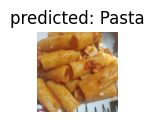

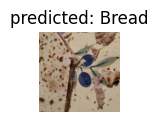

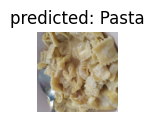

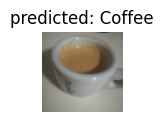

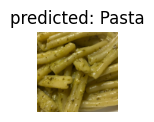

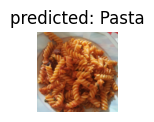

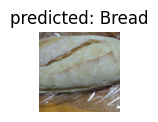

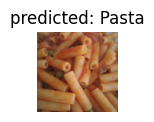

In [15]:
visualize_model(Resnet_fineTuning)
